### DATAFRAME

In [2]:
from cloudvolume import CloudVolume
from meshparty import skeletonize, trimesh_io
from caveclient import CAVEclient
import trimesh
import numpy as np
import datetime
import networkx as nx
from scipy.sparse import identity
from scipy.spatial import distance_matrix
import scipy 
from tqdm import tqdm
# import aws
import pandas as pd
import csv
import pyembree
import matplotlib.pyplot as plt
import scipy.spatial as spatial
import itertools
import math

In [3]:
orphans = pd.read_csv("/Users/sheeltanna/Desktop/AGT_REPO/campfire/ALL_ORPHANS.csv")

In [4]:
def my_array(x):
    res = list(map(str.strip, x.split('; ')))
    return res

In [5]:
orphans['endpoints'] = orphans['endpoints'].map(lambda x: list(map(str.strip, x.split('; '))))

In [6]:
## convert from string list to 2-d array
def convert_to_array(row):
    count = 0
    result = []
    for endpoint in row["endpoints"]:
        endpoint = eval(endpoint)
        if(count == 0):
            result = np.array(endpoint)
            count = count + 1
        else:
            result = np.vstack((result, np.array(endpoint)))
            count = count + 1
    if(count == 1 and result.size != 0):
        result = result.reshape(1,3)
    return result 

In [7]:
orphans["real_endpoints"] = orphans.apply(convert_to_array, axis = 1)

### TIP FINDER FUNCTIONS

In [8]:
def get_and_process_mesh(root_id):
    datastack_name = "minnie65_phase3_v1"
    client = CAVEclient(datastack_name)
    vol = CloudVolume(
        client.info.segmentation_source(),
        use_https=True,
        progress=False,
        bounded=False,
        fill_missing=True,
        secrets={"token": client.auth.token}
    )
    print("Downloading Mesh")
    mesh = vol.mesh.get(str(root_id))[root_id]
    mesh_obj = trimesh.Trimesh(np.divide(mesh.vertices, np.array([1,1,1])), mesh.faces)
    print("Vertices: ", mesh.vertices.shape[0])

    if mesh_obj.volume > 4000000000000:
        print("TOO BIG, SKIPPING")
        return None
    trimesh.repair.fix_normals(mesh_obj)
    mesh_obj.fill_holes()

    return mesh_obj

In [9]:
def get_soma(soma_id:str):
    cave_client = CAVEclient('minnie65_phase3_v1')
    soma = cave_client.materialize.query_table(
        "nucleus_neuron_svm",
        filter_equal_dict={'id':soma_id}
    )
    return soma

In [10]:
def process_mesh_ccs(mesh_obj):
    print("Processing CC's")
    ccs_graph = trimesh.graph.connected_components(mesh_obj.edges)
    ccs_len = [len(c) for c in ccs_graph]
    largest_component = ccs_graph[np.argmax(ccs_len)]
    largest_component_remap = np.arange(ccs_graph[np.argmax(ccs_len)].shape[0])
    face_dict = {largest_component[i]:largest_component_remap[i] for i in range(largest_component.shape[0])}

    new_faces_mask = np.isin(mesh_obj.faces, list(face_dict.keys()))
    new_faces_mask = new_faces_mask[:, 0]*new_faces_mask[:, 1]*new_faces_mask[:, 2]

    new_faces = np.vectorize(face_dict.get)(mesh_obj.faces[new_faces_mask])
    new_faces = new_faces[new_faces[:, 0] != None]
    largest_component_mesh = trimesh.Trimesh(mesh_obj.vertices[largest_component], new_faces)

    all_ids = set(largest_component)
    encapsulated_ids = []

    for i in range(1, len(ccs_graph)):
        n_con = largest_component_mesh.contains(mesh_obj.vertices[ccs_graph[i]])
        if np.sum(n_con) / n_con.shape[0] == 0 and n_con.shape[0] > 50:
            all_ids.update(ccs_graph[i])
        else:
            if len(ccs_graph[i]) < 1000:
                encapsulated_ids.append((np.mean(mesh_obj.vertices[ccs_graph[i]], axis=0)/[4,4,40], len(ccs_graph[i])))
            
    all_component = np.array(list(ccs_graph[np.argmax(ccs_len)]))
    all_component_remap = np.arange(all_component.shape[0])
    face_dict = {all_component[i]:all_component_remap[i] for i in range(all_component.shape[0])}
    new_faces_mask = np.isin(mesh_obj.faces, list(face_dict.keys()))
    new_faces_mask = new_faces_mask[:, 0]*new_faces_mask[:, 1]*new_faces_mask[:, 2]

    new_faces = np.vectorize(face_dict.get)(mesh_obj.faces[new_faces_mask])
    new_faces[new_faces[:, 0] != None]
    
    largest_component_mesh = trimesh.Trimesh(mesh_obj.vertices[all_component], new_faces)
    
    mesh_obj = largest_component_mesh
    return mesh_obj, encapsulated_ids, np.max(ccs_len)

In [11]:
def process_defects(mesh_obj, a=.75):
    bad_edges = trimesh.grouping.group_rows(
        mesh_obj.edges_sorted, require_count=1)
    bad_edges_ind = mesh_obj.edges[bad_edges]
    sparse_edges = mesh_obj.edges_sparse
    xs = list(bad_edges_ind[:, 0]) + list(bad_edges_ind[:, 1]) 
    ys = list(bad_edges_ind[:, 1]) + list(bad_edges_ind[:, 0])
    vs = [1]*bad_edges_ind.shape[0]*2
    bad_inds = scipy.sparse.coo_matrix((vs, (xs, ys)), shape=(mesh_obj.vertices.shape[0], mesh_obj.vertices.shape[0]))
    # Make it symmetrical and add identity so each integrates from itself too, then subtract singleton edges
    # I noticed that the number of asymmetrical edges vs the number of single edges I find from group rows
    # Are close but different. Haven't looked into that yet. Also removing edges 1 hop away from single edges to remove bias towards
    # Holes in the mesh that are caused by mesh construction errors as opposed to segmentation errors
    sparse_edges = mesh_obj.edges_sparse + mesh_obj.edges_sparse.T + identity(mesh_obj.edges_sparse.shape[0]) - sparse_edges.multiply(bad_inds) - bad_inds
    degs = mesh_obj.vertex_degree + 1

    # N_iter is a smoothing parameter here. The loop below smooths the vertex error about the mesh to get more consistent connected regions
    n_iter = 2
    angle_sum = np.array(abs(mesh_obj.face_angles_sparse).sum(axis=1)).flatten()
    defs = (2 * np.pi) - angle_sum

    abs_defs = np.abs(defs)
    abs_defs_i = abs_defs.copy()
    for i in range(n_iter):
        abs_defs_i = sparse_edges.dot(abs_defs_i) / degs
    
    verts_select = np.argwhere((abs_defs_i > a))# & (abs_defs < 2.5))

    edges_mask = np.isin(mesh_obj.edges, verts_select)
    edges_mask[bad_edges] = False
    edges_select = edges_mask[:, 0] * edges_mask[:, 1]
    edges_select = mesh_obj.edges[edges_select]

    G = nx.from_edgelist(edges_select)#f_edge_sub)

    ccs = nx.connected_components(G)
    subgraphs = [G.subgraph(cc).copy() for cc in ccs]

    lens = []
    lengths = []
    for i in tqdm(range(len(subgraphs))):
        ns = np.array(list(subgraphs[i].nodes()))
    #     ns = ns[abs_defs[ns ]]
        l = len(ns)
        if l > 20 and l < 5000:
            lens.append(ns)
            lengths.append(l)
    all_nodes = set()
    for l in lens:
        all_nodes.update(l)
    all_nodes = np.array(list(all_nodes))
    # sharp_pts = mesh_obj.vertices[all_nodes]
    centers = np.array([np.mean(mesh_obj.vertices[list(ppts)],axis=0) for ppts in lens])

    return centers, lens

In [12]:
def process_endpoints(mesh_obj, skel_mp):
    # Process the skeleton to get the endpoints
    interior_cc_mask = set()
    el = nx.from_edgelist(skel_mp.edges)
    comps = list(nx.connected_components(el))
    for c in comps:
        if len(c) < 100:
            n_con = mesh_obj.contains(skel_mp.vertices[list(c)])
            if np.sum(n_con) / n_con.shape[0] > .10:
                interior_cc_mask.update(list(c))
    # Process the skeleton to get the endpoints
    edges = skel_mp.edges.copy()

    edge_mask = ~np.isin(edges, interior_cc_mask)
    edge_mask = edge_mask[:, 0] + edge_mask[:, 1]
    edges = edges[edge_mask]
    edges_flat  = edges.flatten()
    edge_bins = np.bincount(edges_flat) 

    eps = np.squeeze(np.argwhere(edge_bins==1))
    eps_nm = skel_mp.vertices[eps]

    eps_comp = distance_matrix(eps_nm, eps_nm)
    eps_comp[eps_comp == 0] = np.inf
    eps_thresh = np.argwhere(~(np.min(eps_comp, axis=0) < 3000))

    eps = np.squeeze(eps[eps_thresh])
    eps_nm = np.squeeze(eps_nm[eps_thresh])
    return eps, eps_nm

In [13]:
def process_mesh_errors(mesh_obj, centers, eps, eps_nm, lens, skel_mp):
    if eps.size == 1:
        #eps_nm should therefore be reshaped
        eps_nm = eps_nm.reshape((1,3))

    print("Processing mesh errors")
    # path_to_root_dict = {}
    # for ep in eps:
    #     path_to_root_dict[ep] = skel_mp.path_to_root(ep)
        
    dists_defects = np.zeros(centers.shape[0])
    sizes = np.zeros(centers.shape[0])
    mesh_map = skel_mp.mesh_to_skel_map
    closest_skel_pts = mesh_map[[l[0] for l in lens]]

    # print(centers, eps_nm)

    dist_matrix = distance_matrix(centers, eps_nm)
    ct = 0

    closest_tip = np.zeros((centers.shape[0]))

    for center in tqdm(centers):
    #     skel_pts_dists = np.linalg.norm(skel_mp.vertices - center, axis=1)
    #     ep_pts_dists = np.linalg.norm(eps_nm - center, axis=1)
        
        # closest_skel_pt = closest_skel_pts[ct]
        min_ep = np.inf
        eps_hit = []
        if eps.size == 1:
            eps_hit.append(eps)
        else: 
            for j, ep in enumerate(eps):
                # if closest_skel_pt in path_to_root_dict[ep]:
                #     eps_hit.append(j)
                eps_hit.append(j)
        
        if(eps.size == 1):
            dists = dist_matrix[ct]
        else:
            dists = dist_matrix[ct, eps_hit]
        
        amin = np.argmin(dists)
        tip_hit = eps_hit[amin]
        min_dist = dists[amin]
        
        closest_tip[ct] = tip_hit
    #     print(np.argmin(ep_pts_dists), ep_found, eps_nm[np.argmin(ep_pts_dists)]/[4,4,40], eps_nm[j]/[4,4,40], center/[4,4,40])
        dists_defects[ct] = min_dist
        sizes[ct] = len(lens[ct])
        ct+=1
    dists_defects_sub = dists_defects[dists_defects < 5000]
    sizes_sub = sizes[dists_defects < 5000]
    centers_sub = centers[dists_defects < 5000]
    tips_hit_sub = closest_tip[dists_defects < 5000]
    closest_skel_pts_sub = closest_skel_pts[dists_defects < 5000]
    inds_sub = np.arange(centers.shape[0])[dists_defects < 5000]


    # Also ranking each component based on its PCA- if the first component is big enough, the points are mostly linear
    # These point sets seem to be less likely to be true errors
    from sklearn.decomposition import PCA
    pca_vec = np.zeros(inds_sub.shape[0])
    for i in range(inds_sub.shape[0]):
        pca = PCA()#n_components=2)
        pca.fit(mesh_obj.vertices[lens[inds_sub[i]]])

        pca_vec[i] = pca.explained_variance_ratio_[0]

    dists_defects_sub[dists_defects_sub < 4000] = 100
    dists_defects_norm = dists_defects_sub #/ np.max(dists_defects_sub)
    ranks_ep = sizes_sub / dists_defects_norm * (1-pca_vec)
    ranks = sizes_sub**2 * (1-pca_vec)

    #ranks_ep_errors_filt = ranks_ep[ranks_ep > .1]
    centers_ep_send_errors = centers_sub[np.argsort(ranks_ep)][::-1][:20]
    final_mask_eps = np.full(centers_ep_send_errors.shape[0], True)
    tips_hit_send_ep = tips_hit_sub[np.argsort(ranks_ep)][::-1][:20]
    uns, nums = np.unique(tips_hit_send_ep, return_counts=True)

    for un, num in zip(uns, nums):
        if num > 1:
            final_mask_eps[np.argwhere(tips_hit_send_ep == un)[1:]] = False
    centers_errors_ep = centers_ep_send_errors[final_mask_eps]
    centers_errors = centers_sub[np.argsort(ranks)[::-1]][:20]
    return centers_errors, centers_errors_ep

In [14]:
def process_mesh_facets(mesh_obj, skel_mp, eps, eps_nm, facet_area_threshold=30000):

    
    if eps.size == 1:
        #eps_nm should therefore be reshaped
        eps_nm = eps_nm.reshape((1,3))

    #changed threshold of facets to 3000 to match changes performed on processed in analysis CELLS
    print("Processing facets")
    #can possibly change param here
    #threshold on size of flat area
    locs = np.argwhere(mesh_obj.facets_area > facet_area_threshold)

    mesh_map = skel_mp.mesh_to_skel_map
    mesh_coords = mesh_obj.vertices[mesh_obj.faces]
    mean_locs = []
    mesh_ind = []
    fs = []
    for l in tqdm(locs):
        fs.append(np.sum(mesh_obj.facets_area[l]))
        fc = mesh_obj.facets[l[0]]
        vert_locs = mesh_coords[fc]
        mean_locs.append(np.mean(vert_locs[:, 0], axis=0))
        mesh_ind.append(fc[0])
    mesh_ind = mesh_obj.faces[mesh_ind][:, 0]
    mean_locs = np.array(mean_locs)
    if mean_locs.size == 0:
        facets_send_final = np.zeros((1,3))
        return facets_send_final
    dists_defects_facets = np.zeros(mean_locs.shape[0])
    mesh_map_facets = skel_mp.mesh_to_skel_map
    closest_skel_pts_facets = mesh_map[[m for m in mesh_ind]]
    dist_matrix_facets = distance_matrix(mean_locs, eps_nm)
    ct = 0

    closest_tip_facets = np.zeros((mean_locs.shape[0]))

    for center in tqdm(mean_locs):

        closest_skel_pt = closest_skel_pts_facets[ct]
        eps_hit = []
        ##added for error fixing
        if eps.size == 1:
            eps_hit.append(eps)
        else:
            for j, ep in enumerate(eps):
                # if closest_skel_pt in path_to_root_dict[ep]:
                #     eps_hit.append(j)
                eps_hit.append(j)
        
            #distance from every error(facets and jagged) to every endpoint
        if(eps.size == 1):
            dists = dist_matrix_facets[ct]
        else:
            dists = dist_matrix_facets[ct, eps_hit]
    
        
        amin = np.argmin(dists)
        tip_hit = eps_hit[amin]
        min_dist = dists[amin]
        
        closest_tip_facets[ct] = tip_hit
        dists_defects_facets[ct] = min_dist
        ct+=1
    dists_defects_sub_facets = dists_defects_facets[dists_defects_facets < 2000]
    sizes_sub_facets = np.array(fs)[dists_defects_facets < 2000]
    mean_locs_facets = mean_locs[dists_defects_facets < 2000]
    tips_hit_sub_facets = closest_tip_facets[dists_defects_facets < 2000]
    closest_skel_pts_sub_facets = closest_skel_pts_facets[dists_defects_facets < 2000]
    inds_sub_facets = np.arange(mean_locs.shape[0])[dists_defects_facets < 2000]
    # ranks_ep_facets = sizes_sub_facets**2 / dists_defects_sub_facets
    #ranks_ep_facets_filt = ranks_ep_facets[ranks_ep_facets > 2e7]
    mean_locs_send_facets = mean_locs_facets
    final_mask_facets = np.full(mean_locs_send_facets.shape[0], True)
    tips_hit_send_facets = tips_hit_sub_facets
    uns, nums = np.unique(tips_hit_send_facets, return_counts=True)

    for un, num in zip(uns, nums):
        if num > 1:
            final_mask_facets[np.argwhere(tips_hit_send_facets == un)[1:]] = False
    facets_send_final = mean_locs_send_facets[final_mask_facets] / [4,4,40]
    return facets_send_final

### TIP FINDER FUNCTION

In [15]:
def error_locs_defects(root_id, soma_id = None, soma_table=None, center_collapse=True):
    mesh_obj = get_and_process_mesh(root_id)
    if mesh_obj is None:
        return None
    try:
        if soma_table==None:
            soma_table = get_soma(str(soma_id))
        if soma_table[soma_table.id == soma_id].shape[0] > 0:
            center = np.array(soma_table[soma_table.id == soma_id].pt_position)[0] * [4,4,40]
        else:
            center=None
    except:
        center = None
    print("Subselecting largest connected component of mesh")
    mesh_obj, encapsulated_ids, max_verts = process_mesh_ccs(mesh_obj)
    

    skel_mp = skeletonize.skeletonize_mesh(trimesh_io.Mesh(mesh_obj.vertices, 
                                            mesh_obj.faces),
                                            invalidation_d=4000,
                                            shape_function='cone',
                                            collapse_function='branch',
#                                             soma_radius = soma_radius,
                                            soma_pt=center,
                                            smooth_neighborhood=5,
                                             cc_vertex_thresh=max_verts - 10
#                                                     collapse_params = {'dynamic_threshold':True}
                                            )
    print("Skel done")
    centers, lens = process_defects(mesh_obj)
    eps, eps_nm = process_endpoints(mesh_obj, skel_mp)

    if(len(eps) == 0):
        sorted_encapsulated_send = np.zeros((1,3))
        facets_send_final = np.zeros((1,3))
        errors_send = np.zeros((1,3))
        errors_tips_send = np.zeros((1,3))
        return sorted_encapsulated_send, facets_send_final, errors_send, errors_tips_send
        
    
    if len(centers) !=0:
        centers_errors, centers_errors_ep = process_mesh_errors(mesh_obj, centers, eps, eps_nm, lens, skel_mp)
    else:
        centers_errors = np.zeros ((1,3))
        centers_errors_ep = np.zeros ((1,3))
        ranks = np.zeros ((1))
        ranks_ep = np.zeros((1, 3))
        ranks_return = 0
        ranks_ep_return = 0
    facets_send_final = process_mesh_facets(mesh_obj, skel_mp, eps, eps_nm)
    errors_send = centers_errors / [4,4,40]
    errors_tips_send = centers_errors_ep / [4,4,40]
    encapsulated_centers = [e[0] for e in encapsulated_ids]
    encapsulated_lens = [e[1] for e in encapsulated_ids]
    sorted_encapsulated_send = np.array(encapsulated_centers)[np.argsort(encapsulated_lens)][::-1]
    return sorted_encapsulated_send, facets_send_final, errors_send, errors_tips_send

### Generating Endpoints

In [16]:
def find_endpoints_and_counts(row):
    seg_id = row["seg_id"]
    sorted_encapsulated_send, facets_send_final, errors_send, errors_tips_send = error_locs_defects(seg_id)
    
    num_points_error_tips_send = np.sum(np.all(errors_tips_send != 0, axis=1))
    num_points_facets_send_final = np.sum(np.all(facets_send_final != 0, axis=1))
    
    together = np.vstack((facets_send_final, errors_tips_send))
    mask = np.sum(together, axis=1)
    together = together[mask > 0]
    
    return together, num_points_error_tips_send, num_points_facets_send_final

In [17]:
def generate_endpoints(dataframe):
    dataframe["endpoints_generated"], dataframe["num_errors"], dataframe["num_facets"] = zip(*dataframe.apply(find_endpoints_and_counts, axis=1))
    return dataframe

### Accuracy Function

In [18]:
def pred_eps_acc(gt_endpoints, pred_endpoints, threshold):
    # Calculate distances
    dist_matrix = np.array(spatial.distance.cdist(gt_endpoints, pred_endpoints, metric = 'euclidean'))
    # Apply threshold
    dist_matrix[dist_matrix > threshold] = 0
    # Calculating accuracy
    valid_eps = np.count_nonzero(dist_matrix, axis = 1)
    accuracy = np.count_nonzero(valid_eps) / len(gt_endpoints)
    return accuracy

### Testing On Orphans

In [19]:
generate_endpoints(orphans)

Vertices:  7993
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7992/7992 [00:00<00:00, 1067577.87it/s]


Skel done


100%|██████████| 26/26 [00:00<00:00, 98511.21it/s]


Processing facets


100%|██████████| 17/17 [00:00<00:00, 60070.07it/s]


Vertices:  21335
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 21334/21334 [00:00<00:00, 962433.38it/s]


Skel done


100%|██████████| 87/87 [00:00<00:00, 277916.56it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 29330.80it/s]


Processing facets


100%|██████████| 89/89 [00:00<00:00, 79037.28it/s]


Vertices:  2282
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2281/2281 [00:00<00:00, 523656.67it/s]


Skel done


100%|██████████| 11/11 [00:00<00:00, 91724.34it/s]


Vertices:  185182
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 184108/184108 [00:00<00:00, 360972.80it/s]


Skel done


100%|██████████| 783/783 [00:00<00:00, 371761.38it/s]


Processing mesh errors


100%|██████████| 48/48 [00:00<00:00, 64507.08it/s]


Processing facets


100%|██████████| 1002/1002 [00:00<00:00, 94049.43it/s]


Vertices:  234
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 233/233 [00:00<00:00, 75255.88it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 4443.12it/s]


Vertices:  1451
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 1450/1450 [00:00<00:00, 390531.10it/s]


Skel done


100%|██████████| 6/6 [00:00<00:00, 3255.60it/s]


Vertices:  1180
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 1179/1179 [00:00<00:00, 378238.06it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 22617.58it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 4350.94it/s]


Processing facets


100%|██████████| 9/9 [00:00<00:00, 58344.26it/s]


Vertices:  68105
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 68066/68066 [00:00<00:00, 130331.46it/s]


Skel done


100%|██████████| 429/429 [00:00<00:00, 308637.46it/s]


Processing mesh errors


100%|██████████| 41/41 [00:00<00:00, 69369.29it/s]


Processing facets


100%|██████████| 328/328 [00:00<00:00, 91697.11it/s]


Vertices:  677
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 676/676 [00:00<00:00, 161402.03it/s]


Skel done


100%|██████████| 4/4 [00:00<00:00, 42908.48it/s]


Vertices:  11725
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11724/11724 [00:00<00:00, 759725.92it/s]


Skel done


100%|██████████| 44/44 [00:00<00:00, 178308.58it/s]


Processing mesh errors


100%|██████████| 3/3 [00:00<00:00, 34473.73it/s]


Processing facets


100%|██████████| 47/47 [00:00<00:00, 46958.62it/s]


Vertices:  14714
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 14505/14505 [00:00<00:00, 1071437.77it/s]


Skel done


100%|██████████| 91/91 [00:00<00:00, 268600.75it/s]


Processing mesh errors


100%|██████████| 9/9 [00:00<00:00, 54236.69it/s]


Processing facets


100%|██████████| 52/52 [00:00<00:00, 59770.84it/s]


Vertices:  24966
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 24965/24965 [00:00<00:00, 829228.27it/s]


Skel done


100%|██████████| 158/158 [00:00<00:00, 269609.45it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 80238.86it/s]

Processing facets



100%|██████████| 89/89 [00:00<00:00, 102048.40it/s]


Vertices:  23312
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 23105/23105 [00:00<00:00, 793298.90it/s]


Skel done


100%|██████████| 168/168 [00:00<00:00, 270496.38it/s]


Processing mesh errors


100%|██████████| 13/13 [00:00<00:00, 52989.26it/s]


Processing facets


100%|██████████| 71/71 [00:00<00:00, 84745.47it/s]


Vertices:  171
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 170/170 [00:00<00:00, 77706.16it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 11366.68it/s]


Vertices:  316
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 315/315 [00:00<00:00, 168177.92it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 21959.71it/s]


Vertices:  2490
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2489/2489 [00:00<00:00, 665537.59it/s]


Skel done


100%|██████████| 21/21 [00:00<00:00, 137410.90it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 23237.14it/s]


Processing facets


100%|██████████| 5/5 [00:00<00:00, 55627.37it/s]


Vertices:  67
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 66/66 [00:00<00:00, 27083.85it/s]


Skel done


0it [00:00, ?it/s]


Vertices:  167
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 166/166 [00:00<00:00, 60386.34it/s]


Skel done


100%|██████████| 3/3 [00:00<00:00, 34855.71it/s]


Vertices:  413
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 412/412 [00:00<00:00, 145532.53it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 20815.40it/s]


Vertices:  46191
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 46171/46171 [00:00<00:00, 475024.68it/s]


Skel done


100%|██████████| 199/199 [00:00<00:00, 295666.49it/s]


Processing mesh errors


100%|██████████| 17/17 [00:00<00:00, 42722.09it/s]


Processing facets


100%|██████████| 141/141 [00:00<00:00, 90566.14it/s]


Vertices:  7233
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7232/7232 [00:00<00:00, 750821.94it/s]


Skel done


100%|██████████| 50/50 [00:00<00:00, 233535.86it/s]


Processing facets


100%|██████████| 6/6 [00:00<00:00, 17050.02it/s]


Vertices:  80
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 79/79 [00:00<00:00, 39166.67it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 13888.42it/s]


Vertices:  1113
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 1112/1112 [00:00<00:00, 374894.79it/s]


Skel done


100%|██████████| 3/3 [00:00<00:00, 34100.03it/s]


Vertices:  2238
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2237/2237 [00:00<00:00, 564880.08it/s]


Skel done


100%|██████████| 8/8 [00:00<00:00, 10485.76it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 15141.89it/s]


Processing facets


100%|██████████| 8/8 [00:00<00:00, 40622.80it/s]


Vertices:  7187
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7186/7186 [00:00<00:00, 1196659.73it/s]


Skel done


100%|██████████| 39/39 [00:00<00:00, 233682.65it/s]


Processing facets


100%|██████████| 10/10 [00:00<00:00, 67541.13it/s]


Vertices:  460
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 459/459 [00:00<00:00, 157621.22it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 18001.30it/s]


Vertices:  2808
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2807/2807 [00:00<00:00, 741445.39it/s]


Skel done


100%|██████████| 23/23 [00:00<00:00, 156605.51it/s]


Processing facets


100%|██████████| 27/27 [00:00<00:00, 76725.07it/s]


Vertices:  54
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 53/53 [00:00<00:00, 25866.66it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 2777.68it/s]


Vertices:  3001
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3000/3000 [00:00<00:00, 856621.42it/s]


Skel done


100%|██████████| 5/5 [00:00<00:00, 18509.73it/s]


Processing facets


100%|██████████| 10/10 [00:00<00:00, 26817.80it/s]


Vertices:  30924
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 30890/30890 [00:00<00:00, 604393.64it/s]


Skel done


100%|██████████| 144/144 [00:00<00:00, 144735.15it/s]


Processing mesh errors


100%|██████████| 17/17 [00:00<00:00, 66143.94it/s]


Processing facets


100%|██████████| 93/93 [00:00<00:00, 90106.32it/s]


Vertices:  738
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 707/707 [00:00<00:00, 166584.63it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 17586.18it/s]


Vertices:  7233
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7157/7157 [00:00<00:00, 1245793.23it/s]


Skel done


100%|██████████| 46/46 [00:00<00:00, 221259.16it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 30727.50it/s]


Processing facets


100%|██████████| 45/45 [00:00<00:00, 80832.41it/s]


Vertices:  10673
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 10621/10621 [00:00<00:00, 913012.44it/s]


Skel done


100%|██████████| 53/53 [00:00<00:00, 191967.28it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 62468.36it/s]


Processing facets


100%|██████████| 43/43 [00:00<00:00, 38529.18it/s]


Vertices:  14203
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 14202/14202 [00:00<00:00, 1165544.94it/s]


Skel done


100%|██████████| 72/72 [00:00<00:00, 238350.35it/s]


Processing mesh errors


100%|██████████| 4/4 [00:00<00:00, 29905.91it/s]


Processing facets


100%|██████████| 65/65 [00:00<00:00, 37854.73it/s]


Vertices:  4773
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 4766/4766 [00:00<00:00, 723752.82it/s]


Skel done


100%|██████████| 30/30 [00:00<00:00, 58254.22it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 27060.03it/s]


Processing facets


100%|██████████| 27/27 [00:00<00:00, 108473.38it/s]


Vertices:  9476
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 9423/9423 [00:00<00:00, 942278.43it/s]


Skel done


100%|██████████| 66/66 [00:00<00:00, 214925.52it/s]


Processing mesh errors


100%|██████████| 8/8 [00:00<00:00, 63310.25it/s]


Processing facets


100%|██████████| 52/52 [00:00<00:00, 104556.00it/s]


Vertices:  31310
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 31273/31273 [00:00<00:00, 973262.02it/s]


Skel done


100%|██████████| 135/135 [00:00<00:00, 119357.30it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 17623.13it/s]


Processing facets


100%|██████████| 153/153 [00:00<00:00, 102137.28it/s]


Vertices:  58138
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 58016/58016 [00:00<00:00, 483954.62it/s]


Skel done


100%|██████████| 378/378 [00:00<00:00, 306781.52it/s]


Processing mesh errors


100%|██████████| 25/25 [00:00<00:00, 56073.58it/s]


Processing facets


100%|██████████| 281/281 [00:00<00:00, 99754.50it/s]


Vertices:  13251
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 13160/13160 [00:00<00:00, 1353100.79it/s]


Skel done


100%|██████████| 58/58 [00:00<00:00, 223183.15it/s]


Processing mesh errors


100%|██████████| 4/4 [00:00<00:00, 33621.68it/s]


Processing facets


100%|██████████| 59/59 [00:00<00:00, 49611.86it/s]


Vertices:  211159
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 210803/210803 [00:00<00:00, 218039.80it/s]


Skel done


100%|██████████| 879/879 [00:00<00:00, 336416.94it/s]


Processing mesh errors


100%|██████████| 48/48 [00:00<00:00, 74898.29it/s]


Processing facets


100%|██████████| 1160/1160 [00:00<00:00, 93097.96it/s]


Vertices:  37346
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 37089/37089 [00:00<00:00, 498735.36it/s]


Skel done


100%|██████████| 158/158 [00:00<00:00, 265611.24it/s]


Processing mesh errors


100%|██████████| 14/14 [00:00<00:00, 44586.38it/s]


Processing facets


100%|██████████| 183/183 [00:00<00:00, 92088.50it/s]


Vertices:  54492
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 53939/53939 [00:00<00:00, 518973.33it/s]


Skel done


100%|██████████| 342/342 [00:00<00:00, 238796.73it/s]


Processing mesh errors


100%|██████████| 24/24 [00:00<00:00, 32263.88it/s]


Processing facets


100%|██████████| 146/146 [00:00<00:00, 106480.33it/s]


Vertices:  31053
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 30446/30446 [00:00<00:00, 765205.44it/s]


Skel done


100%|██████████| 150/150 [00:00<00:00, 156115.53it/s]


Processing mesh errors


100%|██████████| 18/18 [00:00<00:00, 14183.26it/s]

Processing facets



100%|██████████| 218/218 [00:00<00:00, 88147.91it/s]


Vertices:  11809
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11797/11797 [00:00<00:00, 1178998.39it/s]


Skel done


100%|██████████| 86/86 [00:00<00:00, 241439.19it/s]


Processing mesh errors


100%|██████████| 9/9 [00:00<00:00, 54236.69it/s]


Processing facets


100%|██████████| 57/57 [00:00<00:00, 106968.83it/s]


Vertices:  25267
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 25219/25219 [00:00<00:00, 1022624.16it/s]


Skel done


100%|██████████| 158/158 [00:00<00:00, 235501.08it/s]


Processing mesh errors


100%|██████████| 13/13 [00:00<00:00, 42202.75it/s]


Processing facets


100%|██████████| 179/179 [00:00<00:00, 106872.66it/s]


Vertices:  52186
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 52169/52169 [00:00<00:00, 1002421.82it/s]


Skel done


100%|██████████| 233/233 [00:00<00:00, 308190.74it/s]


Processing mesh errors


100%|██████████| 13/13 [00:00<00:00, 33951.40it/s]


Processing facets


100%|██████████| 247/247 [00:00<00:00, 97121.32it/s]


Vertices:  423059
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 422471/422471 [00:02<00:00, 143984.35it/s]


Skel done


100%|██████████| 2288/2288 [00:00<00:00, 90697.08it/s]


Processing mesh errors


100%|██████████| 137/137 [00:00<00:00, 10932.02it/s]


Processing facets


100%|██████████| 1984/1984 [00:00<00:00, 86456.24it/s]


Vertices:  7500
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7409/7409 [00:00<00:00, 1212753.60it/s]


Skel done


100%|██████████| 49/49 [00:00<00:00, 35873.78it/s]


Processing mesh errors


100%|██████████| 5/5 [00:00<00:00, 56833.39it/s]


Processing facets


100%|██████████| 30/30 [00:00<00:00, 72482.21it/s]


Vertices:  16722
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 16695/16695 [00:00<00:00, 1063902.05it/s]


Skel done


100%|██████████| 105/105 [00:00<00:00, 250655.62it/s]


Processing mesh errors


100%|██████████| 9/9 [00:00<00:00, 53242.22it/s]


Processing facets


100%|██████████| 85/85 [00:00<00:00, 104274.89it/s]


Vertices:  35236
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 35116/35116 [00:00<00:00, 1069445.04it/s]


Skel done


100%|██████████| 158/158 [00:00<00:00, 184596.11it/s]


Processing mesh errors


100%|██████████| 3/3 [00:00<00:00, 38479.85it/s]

Processing facets



100%|██████████| 170/170 [00:00<00:00, 112643.24it/s]


Vertices:  35955
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 35866/35866 [00:00<00:00, 684803.81it/s]


Skel done


100%|██████████| 242/242 [00:00<00:00, 298799.40it/s]


Processing mesh errors


100%|██████████| 21/21 [00:00<00:00, 55119.14it/s]

Processing facets



100%|██████████| 154/154 [00:00<00:00, 87345.88it/s]


Vertices:  3302
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3301/3301 [00:00<00:00, 790127.12it/s]


Skel done


100%|██████████| 23/23 [00:00<00:00, 130539.91it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]


Processing facets


100%|██████████| 11/11 [00:00<00:00, 62432.13it/s]


Vertices:  22842
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 22824/22824 [00:00<00:00, 1021215.62it/s]


Skel done


100%|██████████| 115/115 [00:00<00:00, 296280.69it/s]


Processing mesh errors


100%|██████████| 5/5 [00:00<00:00, 45003.26it/s]

Processing facets



100%|██████████| 88/88 [00:00<00:00, 83167.81it/s]


Vertices:  304
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 303/303 [00:00<00:00, 333387.75it/s]


Skel done


100%|██████████| 4/4 [00:00<00:00, 5601.74it/s]


Vertices:  1869
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 1868/1868 [00:00<00:00, 515729.32it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 95808.97it/s]


Processing facets


100%|██████████| 12/12 [00:00<00:00, 80530.64it/s]


Vertices:  148888
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 148597/148597 [00:01<00:00, 119863.25it/s]


Skel done


100%|██████████| 879/879 [00:00<00:00, 258686.02it/s]


Processing mesh errors


100%|██████████| 90/90 [00:00<00:00, 74250.07it/s]


Processing facets


100%|██████████| 864/864 [00:00<00:00, 97392.53it/s]


Vertices:  806
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 805/805 [00:00<00:00, 236908.13it/s]


Skel done


100%|██████████| 7/7 [00:00<00:00, 70071.90it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 13888.42it/s]


Processing facets


0it [00:00, ?it/s]


Vertices:  11858
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11857/11857 [00:00<00:00, 732007.57it/s]


Skel done


100%|██████████| 36/36 [00:00<00:00, 181049.09it/s]


Processing facets


100%|██████████| 51/51 [00:00<00:00, 93085.08it/s]


Vertices:  16084
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 16033/16033 [00:00<00:00, 1231702.77it/s]


Skel done


100%|██████████| 87/87 [00:00<00:00, 263659.28it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 59796.59it/s]


Processing facets


100%|██████████| 91/91 [00:00<00:00, 58666.10it/s]


Vertices:  528
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 527/527 [00:00<00:00, 214747.71it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 18978.75it/s]


Processing facets


100%|██████████| 12/12 [00:00<00:00, 68571.73it/s]


Vertices:  61226
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 61096/61096 [00:00<00:00, 835365.98it/s]


Skel done


100%|██████████| 178/178 [00:00<00:00, 283873.05it/s]


Processing mesh errors


100%|██████████| 12/12 [00:00<00:00, 73584.28it/s]


Processing facets


100%|██████████| 153/153 [00:00<00:00, 97749.96it/s]


Vertices:  7735
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 7727/7727 [00:00<00:00, 1216888.33it/s]


Skel done


100%|██████████| 37/37 [00:00<00:00, 195946.02it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 26715.31it/s]

Processing facets



100%|██████████| 38/38 [00:00<00:00, 100748.14it/s]


Vertices:  15732
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 15673/15673 [00:00<00:00, 1303923.96it/s]


Skel done


100%|██████████| 67/67 [00:00<00:00, 98533.79it/s]


Processing mesh errors


100%|██████████| 5/5 [00:00<00:00, 55480.21it/s]

Processing facets



100%|██████████| 83/83 [00:00<00:00, 109784.68it/s]


Vertices:  110
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 109/109 [00:00<00:00, 38434.56it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 5194.18it/s]


Vertices:  100996
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 100854/100854 [00:00<00:00, 236369.66it/s]


Skel done


100%|██████████| 455/455 [00:00<00:00, 262540.70it/s]


Processing mesh errors


100%|██████████| 31/31 [00:00<00:00, 39786.85it/s]


Processing facets


100%|██████████| 492/492 [00:00<00:00, 121359.54it/s]


Vertices:  88632
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 88512/88512 [00:00<00:00, 376998.48it/s]


Skel done


100%|██████████| 458/458 [00:00<00:00, 388864.62it/s]


Processing mesh errors


100%|██████████| 25/25 [00:00<00:00, 60228.37it/s]


Processing facets


100%|██████████| 316/316 [00:00<00:00, 30454.26it/s]


Vertices:  38883
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 38834/38834 [00:00<00:00, 542707.12it/s]


Skel done


100%|██████████| 208/208 [00:00<00:00, 185344.22it/s]


Processing mesh errors


100%|██████████| 19/19 [00:00<00:00, 79137.81it/s]


Processing facets


100%|██████████| 228/228 [00:00<00:00, 103697.82it/s]


Vertices:  4897
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 4896/4896 [00:00<00:00, 963014.09it/s]


Skel done


100%|██████████| 25/25 [00:00<00:00, 162318.27it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 28926.23it/s]


Processing facets


100%|██████████| 9/9 [00:00<00:00, 65196.44it/s]


Vertices:  79906
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 79862/79862 [00:00<00:00, 264369.99it/s]


Skel done


100%|██████████| 505/505 [00:00<00:00, 316232.24it/s]


Processing mesh errors


100%|██████████| 42/42 [00:00<00:00, 51995.50it/s]


Processing facets


100%|██████████| 363/363 [00:00<00:00, 75045.96it/s]


Vertices:  17683
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 17673/17673 [00:00<00:00, 762134.20it/s]


Skel done


100%|██████████| 107/107 [00:00<00:00, 197879.42it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 6500.05it/s]


Processing facets


100%|██████████| 52/52 [00:00<00:00, 79109.11it/s]


Vertices:  18981
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 18968/18968 [00:00<00:00, 669253.91it/s]


Skel done


100%|██████████| 125/125 [00:00<00:00, 239510.28it/s]


Processing mesh errors


100%|██████████| 13/13 [00:00<00:00, 22484.93it/s]

Processing facets



100%|██████████| 54/54 [00:00<00:00, 72500.77it/s]


Vertices:  68355
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 68316/68316 [00:00<00:00, 497970.28it/s]


Skel done


100%|██████████| 397/397 [00:00<00:00, 232010.41it/s]


Processing mesh errors


100%|██████████| 30/30 [00:00<00:00, 43736.23it/s]


Processing facets


100%|██████████| 354/354 [00:00<00:00, 98801.15it/s]


Vertices:  2624
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2623/2623 [00:00<00:00, 673419.81it/s]


Skel done


100%|██████████| 23/23 [00:00<00:00, 148642.51it/s]


Vertices:  47772
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 47752/47752 [00:00<00:00, 950837.94it/s]


Skel done


100%|██████████| 255/255 [00:00<00:00, 254957.69it/s]


Processing mesh errors


100%|██████████| 17/17 [00:00<00:00, 23879.16it/s]


Processing facets


100%|██████████| 199/199 [00:00<00:00, 103210.89it/s]


Vertices:  73440
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 73391/73391 [00:00<00:00, 303125.72it/s]


Skel done


100%|██████████| 421/421 [00:00<00:00, 312531.32it/s]


Processing mesh errors


100%|██████████| 18/18 [00:00<00:00, 27563.88it/s]


Processing facets


100%|██████████| 419/419 [00:00<00:00, 119130.52it/s]


Vertices:  9676
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 9662/9662 [00:00<00:00, 1256444.63it/s]


Skel done


100%|██████████| 64/64 [00:00<00:00, 112081.61it/s]


Processing mesh errors


100%|██████████| 5/5 [00:00<00:00, 37117.73it/s]


Processing facets


100%|██████████| 26/26 [00:00<00:00, 86343.55it/s]


Vertices:  3957
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3950/3950 [00:00<00:00, 434637.20it/s]


Skel done


100%|██████████| 17/17 [00:00<00:00, 122303.89it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 26973.02it/s]


Processing facets


100%|██████████| 31/31 [00:00<00:00, 79866.97it/s]


Vertices:  971
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 970/970 [00:00<00:00, 258545.68it/s]


Skel done


100%|██████████| 5/5 [00:00<00:00, 46294.75it/s]


Processing facets


100%|██████████| 2/2 [00:00<00:00, 14952.96it/s]


Vertices:  5808
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 5807/5807 [00:00<00:00, 367642.62it/s]


Skel done


100%|██████████| 38/38 [00:00<00:00, 181737.23it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 31003.30it/s]


Processing facets


100%|██████████| 30/30 [00:00<00:00, 93762.38it/s]


Vertices:  12089
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11967/11967 [00:00<00:00, 821345.35it/s]


Skel done


100%|██████████| 54/54 [00:00<00:00, 142537.71it/s]


Processing mesh errors


100%|██████████| 4/4 [00:00<00:00, 14500.62it/s]


Processing facets


100%|██████████| 82/82 [00:00<00:00, 90915.39it/s]


Vertices:  15375
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 15204/15204 [00:00<00:00, 840275.63it/s]


Skel done


100%|██████████| 68/68 [00:00<00:00, 153175.44it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 3267.86it/s]


Processing facets


100%|██████████| 75/75 [00:00<00:00, 73326.99it/s]


Vertices:  2424
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2423/2423 [00:00<00:00, 354030.47it/s]


Skel done


100%|██████████| 18/18 [00:00<00:00, 39903.53it/s]


Processing mesh errors


100%|██████████| 3/3 [00:00<00:00, 38362.54it/s]


Processing facets


100%|██████████| 8/8 [00:00<00:00, 34771.43it/s]


Vertices:  2722
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2721/2721 [00:00<00:00, 571034.78it/s]


Skel done


100%|██████████| 21/21 [00:00<00:00, 83251.78it/s]


Processing mesh errors


100%|██████████| 3/3 [00:00<00:00, 8399.81it/s]


Processing facets


100%|██████████| 10/10 [00:00<00:00, 86302.55it/s]


Vertices:  22862
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 22838/22838 [00:00<00:00, 307703.10it/s]


Skel done


100%|██████████| 171/171 [00:00<00:00, 267621.64it/s]


Processing mesh errors


100%|██████████| 14/14 [00:00<00:00, 39330.38it/s]


Processing facets


100%|██████████| 81/81 [00:00<00:00, 91524.41it/s]


Vertices:  382
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 381/381 [00:00<00:00, 193302.26it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 12483.05it/s]


Vertices:  211
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 210/210 [00:00<00:00, 191729.18it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 9686.61it/s]


Vertices:  15665
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 15662/15662 [00:00<00:00, 580377.51it/s]


Skel done


100%|██████████| 103/103 [00:00<00:00, 195746.86it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 5813.31it/s]

Processing facets



100%|██████████| 35/35 [00:00<00:00, 65186.79it/s]


Vertices:  12138
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 12099/12099 [00:00<00:00, 1132869.38it/s]


Skel done


100%|██████████| 70/70 [00:00<00:00, 213373.02it/s]


Processing mesh errors


100%|██████████| 3/3 [00:00<00:00, 17949.95it/s]


Processing facets


100%|██████████| 57/57 [00:00<00:00, 102739.72it/s]


Vertices:  13860
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 13828/13828 [00:00<00:00, 998052.65it/s]


Skel done


100%|██████████| 44/44 [00:00<00:00, 222081.08it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 14122.24it/s]


Processing facets


100%|██████████| 63/63 [00:00<00:00, 106035.78it/s]


Vertices:  5724
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 5723/5723 [00:00<00:00, 1160398.42it/s]


Skel done


100%|██████████| 30/30 [00:00<00:00, 158076.78it/s]


Processing facets


100%|██████████| 10/10 [00:00<00:00, 55480.21it/s]


Vertices:  9557
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 9550/9550 [00:00<00:00, 1321007.95it/s]


Skel done


100%|██████████| 47/47 [00:00<00:00, 205132.45it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 25266.89it/s]


Processing facets


100%|██████████| 26/26 [00:00<00:00, 90876.59it/s]


Vertices:  2020
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 2019/2019 [00:00<00:00, 669854.44it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 47127.01it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 4165.15it/s]


Processing facets


100%|██████████| 12/12 [00:00<00:00, 67468.70it/s]


Vertices:  18265
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 18129/18129 [00:00<00:00, 916347.76it/s]


Skel done


100%|██████████| 93/93 [00:00<00:00, 223535.97it/s]


Processing mesh errors


100%|██████████| 4/4 [00:00<00:00, 42153.81it/s]

Processing facets



100%|██████████| 39/39 [00:00<00:00, 82992.32it/s]


Vertices:  35
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 34/34 [00:00<00:00, 5281.32it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 11618.57it/s]


Vertices:  254074
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 253660/253660 [00:01<00:00, 243204.14it/s]


Skel done


100%|██████████| 1160/1160 [00:00<00:00, 270765.91it/s]


Processing mesh errors


100%|██████████| 90/90 [00:00<00:00, 86381.55it/s]

Processing facets



100%|██████████| 2076/2076 [00:00<00:00, 95575.16it/s]


Vertices:  67155
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 67111/67111 [00:00<00:00, 689251.07it/s]


Skel done


100%|██████████| 288/288 [00:00<00:00, 321095.04it/s]


Processing mesh errors


100%|██████████| 12/12 [00:00<00:00, 68947.46it/s]


Processing facets


100%|██████████| 306/306 [00:00<00:00, 93403.47it/s]


Vertices:  44825
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 44696/44696 [00:00<00:00, 647365.43it/s]


Skel done


100%|██████████| 250/250 [00:00<00:00, 322143.16it/s]


Processing mesh errors


100%|██████████| 23/23 [00:00<00:00, 42516.08it/s]


Processing facets


100%|██████████| 295/295 [00:00<00:00, 95590.21it/s]


Vertices:  304
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 303/303 [00:00<00:00, 132080.04it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 29330.80it/s]


Vertices:  11531
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 11530/11530 [00:00<00:00, 1383660.70it/s]


Skel done


100%|██████████| 77/77 [00:00<00:00, 221814.15it/s]


Processing mesh errors


100%|██████████| 6/6 [00:00<00:00, 30578.16it/s]


Processing facets


100%|██████████| 62/62 [00:00<00:00, 46445.23it/s]


Vertices:  113
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 112/112 [00:00<00:00, 62911.75it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 12826.62it/s]


Vertices:  3820
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3801/3801 [00:00<00:00, 679823.87it/s]


Skel done


100%|██████████| 28/28 [00:00<00:00, 150564.76it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 27060.03it/s]


Processing facets


100%|██████████| 14/14 [00:00<00:00, 80881.90it/s]


Vertices:  277
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 276/276 [00:00<00:00, 116755.21it/s]


Skel done


100%|██████████| 3/3 [00:00<00:00, 33376.42it/s]


Vertices:  24046
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 24033/24033 [00:00<00:00, 904887.10it/s]


Skel done


100%|██████████| 172/172 [00:00<00:00, 257558.12it/s]


Processing mesh errors


100%|██████████| 7/7 [00:00<00:00, 28339.89it/s]

Processing facets



100%|██████████| 43/43 [00:00<00:00, 60992.58it/s]


Vertices:  58
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 57/57 [00:00<00:00, 31141.76it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 11491.24it/s]


Vertices:  244554
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 244251/244251 [00:01<00:00, 229933.08it/s]


Skel done


100%|██████████| 1637/1637 [00:00<00:00, 351331.71it/s]


Processing mesh errors


100%|██████████| 102/102 [00:00<00:00, 68221.82it/s]


Processing facets


100%|██████████| 791/791 [00:00<00:00, 88084.28it/s]


Vertices:  389
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 388/388 [00:00<00:00, 170175.67it/s]


Skel done


100%|██████████| 4/4 [00:00<00:00, 40136.88it/s]


Vertices:  257
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 256/256 [00:00<00:00, 149733.90it/s]


Skel done


100%|██████████| 1/1 [00:00<00:00, 4609.13it/s]


Vertices:  533
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 532/532 [00:00<00:00, 213835.14it/s]


Skel done


100%|██████████| 4/4 [00:00<00:00, 39290.90it/s]


Vertices:  3065
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3060/3060 [00:00<00:00, 809139.47it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 47904.49it/s]


Processing facets


100%|██████████| 16/16 [00:00<00:00, 93596.74it/s]


Vertices:  5754
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 5753/5753 [00:00<00:00, 1169307.57it/s]


Skel done


100%|██████████| 18/18 [00:00<00:00, 100529.26it/s]


Processing facets


100%|██████████| 15/15 [00:00<00:00, 23669.89it/s]


Vertices:  10302
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 10202/10202 [00:00<00:00, 913190.69it/s]


Skel done


100%|██████████| 75/75 [00:00<00:00, 120803.69it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 12941.75it/s]


Processing facets


100%|██████████| 30/30 [00:00<00:00, 93206.76it/s]


Vertices:  27011
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 27009/27009 [00:00<00:00, 225969.55it/s]


Skel done


100%|██████████| 154/154 [00:00<00:00, 158625.45it/s]


Processing mesh errors


100%|██████████| 11/11 [00:00<00:00, 23868.26it/s]


Processing facets


100%|██████████| 70/70 [00:00<00:00, 78293.67it/s]


Vertices:  3523
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 3522/3522 [00:00<00:00, 686160.00it/s]


Skel done


100%|██████████| 29/29 [00:00<00:00, 36439.43it/s]


Processing mesh errors


100%|██████████| 5/5 [00:00<00:00, 9619.96it/s]


Processing facets


100%|██████████| 8/8 [00:00<00:00, 63429.93it/s]


Vertices:  172
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 171/171 [00:00<00:00, 131311.97it/s]


Skel done


100%|██████████| 3/3 [00:00<00:00, 41527.76it/s]


Vertices:  42061
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 42038/42038 [00:00<00:00, 376691.29it/s]


Skel done


100%|██████████| 269/269 [00:00<00:00, 271675.36it/s]


Processing mesh errors


100%|██████████| 23/23 [00:00<00:00, 45439.94it/s]


Processing facets


100%|██████████| 87/87 [00:00<00:00, 98092.59it/s]


Vertices:  23856
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 23484/23484 [00:00<00:00, 718430.93it/s]


Skel done


100%|██████████| 151/151 [00:00<00:00, 262687.64it/s]


Processing mesh errors


100%|██████████| 16/16 [00:00<00:00, 26704.68it/s]


Processing facets


100%|██████████| 90/90 [00:00<00:00, 87199.67it/s]


Vertices:  31640
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 31589/31589 [00:00<00:00, 848438.60it/s]


Skel done


100%|██████████| 138/138 [00:00<00:00, 177823.03it/s]


Processing mesh errors


100%|██████████| 5/5 [00:00<00:00, 38199.49it/s]


Processing facets


100%|██████████| 119/119 [00:00<00:00, 105948.24it/s]


Vertices:  198
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 197/197 [00:00<00:00, 90323.34it/s]


Skel done


100%|██████████| 2/2 [00:00<00:00, 25970.92it/s]


Vertices:  26717
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 26716/26716 [00:00<00:00, 717014.50it/s]


Skel done


100%|██████████| 170/170 [00:00<00:00, 255658.54it/s]


Processing mesh errors


100%|██████████| 17/17 [00:00<00:00, 84582.64it/s]

Processing facets



100%|██████████| 57/57 [00:00<00:00, 85201.47it/s]


Vertices:  5089
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 5088/5088 [00:00<00:00, 661888.80it/s]


Skel done


100%|██████████| 30/30 [00:00<00:00, 173318.35it/s]


Processing mesh errors


100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]


Processing facets


100%|██████████| 24/24 [00:00<00:00, 63191.02it/s]


Vertices:  26753
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 26554/26554 [00:00<00:00, 667123.18it/s]


Skel done


100%|██████████| 144/144 [00:00<00:00, 258000.76it/s]


Processing mesh errors


100%|██████████| 18/18 [00:00<00:00, 85211.59it/s]

Processing facets



100%|██████████| 129/129 [00:00<00:00, 89952.65it/s]


Vertices:  19551
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 19465/19465 [00:00<00:00, 1362496.08it/s]


Skel done


100%|██████████| 123/123 [00:00<00:00, 248986.19it/s]


Processing mesh errors


100%|██████████| 13/13 [00:00<00:00, 87241.52it/s]

Processing facets



100%|██████████| 122/122 [00:00<00:00, 70726.34it/s]


Vertices:  1631
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 1630/1630 [00:00<00:00, 422175.84it/s]


Skel done


100%|██████████| 9/9 [00:00<00:00, 21314.93it/s]


Processing mesh errors


100%|██████████| 2/2 [00:00<00:00, 21024.08it/s]


Processing facets


100%|██████████| 12/12 [00:00<00:00, 79512.87it/s]


Vertices:  18937
Subselecting largest connected component of mesh
Processing CC's


100%|██████████| 18924/18924 [00:00<00:00, 595602.81it/s]


Skel done


100%|██████████| 121/121 [00:00<00:00, 156735.88it/s]


Processing mesh errors


100%|██████████| 13/13 [00:00<00:00, 64375.39it/s]

Processing facets



100%|██████████| 66/66 [00:00<00:00, 82290.15it/s]


,neuron,ng_link,seg_id,pink_pts,num_endpoints,endpoints,comments,detailed_comments,real_endpoints,endpoints_generated,num_errors,num_facets
0,864691136577830164,https://neuroglancer.neuvue.io/?json_url=https...,864691135909994000,"(402188, 228684, 24029)",2,"[(402584, 228856, 23991), (402985, 229235, 235...",good,NaN,"[[402584, 228856, 23991], [402985, 229235, 235...","[[402970.1091549296, 229214.63028169013, 23552...",0,2
1,864691136577830164,https://neuroglancer.neuvue.io/?json_url=https...,864691135247440303,"(401258, 224832, 24029)",3,"[(401612, 224623, 23991), (405257, 226318, 236...",good,NaN,"[[401612, 224623, 23991], [405257, 226318, 236...","[[405014.6845794392, 226607.61448598132, 23618...",1,3
2,864691136577830164,https://neuroglancer.neuvue.io/?json_url=https...,864691134794123793,"(401314, 228366, 24424)",2,"[(401242, 228382, 24444), (400982, 228457, 245...",m,merged to two axon pieces,"[[401242, 228382, 24444], [400982, 228457, 245...",[],0,0
3,864691136577830164,https://neuroglancer.neuvue.io/?json_url=https...,864691135772363453,"(400199, 220721, 24029)",7,"[(401289, 218721, 23991), (399895, 216533, 235...",m,NaN,"[[401289, 218721, 23991], [399895, 216533, 235...","[[399920.325, 216558.3, 23517.375], [401217.25...",9,10
4,864691136577830164,https://neuroglancer.neuvue.io/?json_url=https...,864691135314714227,"(397870, 232292, 24004)",2,"[(397867, 232230, 23999), (397854, 232252, 239...",good,NaN,"[[397867, 232230, 23999], [397854, 232252, 239...",[],0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
119,864691135526309723,https://neuroglancer.neuvue.io/?json_url=https...,864691135089638001,"(122738, 154726, 20654)",2,"[(122789, 154701, 20649), (122688, 151314, 205...",good,NaN,"[[122789, 154701, 20649], [122688, 151314, 205...","[[122716.125, 154749.0, 20649.3]]",0,1
120,864691135526309723,https://neuroglancer.neuvue.io/?json_url=https...,864691135319600870,"(106639, 111664, 20802)",2,"[(106608, 111803, 20796), (98290, 97555, 21045)]",good,NaN,"[[106608, 111803, 20796], [98290, 97555, 21045]]","[[98335.2794117647, 97571.25, 21045.675], [106...",3,2
121,864691135526309723,https://neuroglancer.neuvue.io/?json_url=https...,864691136558839249,"(103176, 188510, 21202)",2,"[(103138, 188530, 21200), (91780, 189141, 20879)]",good,NaN,"[[103138, 188530, 21200], [91780, 189141, 20879]]","[[91735.62096774194, 189119.98790322582, 20877...",2,2
122,864691135526309723,https://neuroglancer.neuvue.io/?json_url=https...,864691135458639120,"(127406, 206585, 21529)",2,"[(127475, 206611, 21525), (128120, 207267, 215...",good,NaN,"[[127475, 206611, 21525], [128120, 207267, 215...","[[127722.0, 206896.375, 21513.45], [127879.5, ...",1,2


In [20]:
#apply function to entire df 
count = 0
acc_array = []
for index, row in orphans.iterrows():
    if (type(row["real_endpoints"])== list and type(row["endpoints_generated"]) == list):
        acc = 1
        print("both empty")
    elif(type(row["endpoints_generated"]) == list and type(row["real_endpoints"]) != list):
        acc = 0
        print("no endpoints generated, but endpoints exist")
    else:
        count = count + 1
        acc = pred_eps_acc(row["real_endpoints"], row["endpoints_generated"], 250)
        acc_array.append(acc)

In [21]:
acc_array = np.array(acc_array)

print(acc_array)

[1.         1.         0.         0.75       0.         0.
 1.         0.4        0.         0.4        0.5        1.
 0.5        0.         0.         1.         0.         0.
 0.         1.         0.         0.         0.         1.
 0.         0.         0.33333333 0.         0.5        0.5
 0.         0.5        0.         0.5        0.5        0.66666667
 0.5        0.6        1.         0.85714286 0.66666667 0.66666667
 0.5        0.33333333 1.         0.5        0.45454545 0.5
 0.66666667 0.66666667 0.33333333 0.5        0.5        0.
 0.         0.25       0.66666667 0.66666667 1.         1.
 1.         1.         0.5        0.         0.5        1.
 0.66666667 1.         0.85714286 0.5        0.5        0.8
 0.         0.5        1.         0.5        0.5        1.
 1.         0.5        0.66666667 0.5        0.5        0.5
 0.         0.         0.66666667 0.5        0.5        0.5
 0.5        1.         0.5        0.         1.         0.5
 1.         0.         1.         

In [22]:
counter = 0
for acc in acc_array:
    if acc >= 0.5:
        counter = counter + 1

print(counter)

82


In [23]:
len(acc_array)

124

### Final Dataframe

In [26]:
orphans["num_gen_endpoints"] = orphans["endpoints_generated"].apply(lambda x: len(x))

In [30]:
# Group by neuron column and calculate the sums
grouped_data = orphans.groupby("neuron").agg({
    "num_gen_endpoints": "sum",
    "num_errors": "sum",
    "num_facets": "sum"
}).reset_index()

# Rename the columns
grouped_data = grouped_data.rename(columns={
    "neuron": "Neuron",
    "num_gen_endpoints": "total_gen_endpoints",
    "num_errors": "total_errors",
    "num_facets": "total_facets"
})

# Print the resulting dataframe
print(grouped_data)

                Neuron  total_gen_endpoints  total_errors  total_facets
0   864691135334773481                   44            19            25
1   864691135360418631                    4             0             4
2   864691135396741921                   50            21            29
3   864691135445907602                   35            16            19
4   864691135463797061                   39            19            20
5   864691135501859650                   91            40            51
6   864691135526309723                   30            14            16
7   864691135544674088                   54            21            33
8   864691135614361291                   59            24            35
9   864691135614368971                   45            15            30
10  864691135683615218                   44            18            26
11  864691135837578899                    8             1             7
12  864691135864989916                   11             5       

In [29]:
import os

# Get the path to the "Downloads" folder
downloads_path = os.path.expanduser("~/Downloads")

# Specify the output file path
output_path = os.path.join(downloads_path, "output.xlsx")

# Export the dataframe to Excel
orphans.to_excel(output_path, index=False)

In [50]:
gt = orphans = pd.read_csv("/Users/sheeltanna/Desktop/AGT_REPO/campfire/gt.csv")

In [51]:
gt

,Neuron,Orphans,Total Endpoints
0,864691136577830164,6,18
1,864691135683615218,12,30
2,864691135864989916,2,4
3,864691135837578899,9,19
4,864691135501859650,14,39
5,864691135544674088,5,21
6,864691135614368971,12,35
7,864691135334773481,7,15
8,864691135614361291,11,29
9,864691135445907602,10,24


In [ ]:
gt["Neuron "]

### Figures

ADD accuracy plot HERE

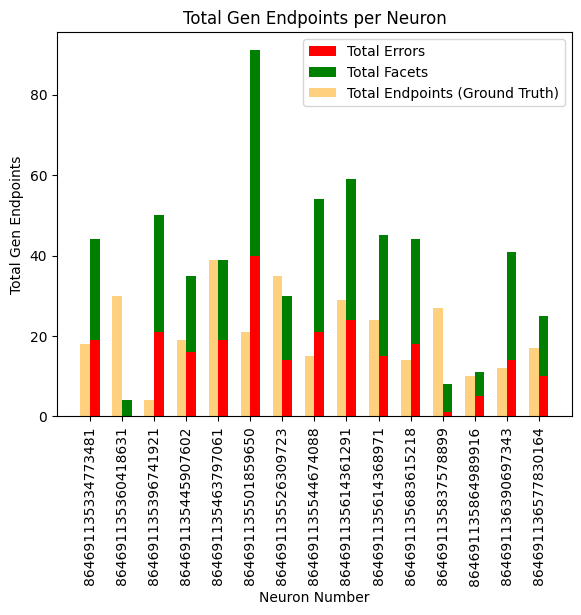

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data from the existing dataframe
existing_neuron_numbers = grouped_data["Neuron"].astype(str)
existing_total_gen_endpoints = grouped_data["total_gen_endpoints"]
existing_total_errors = grouped_data["total_errors"]
existing_total_facets = grouped_data["total_facets"]

# Prepare the data from the ground truth dataframe
ground_truth_neuron_numbers = gt["Neuron "].astype(str)
ground_truth_total_endpoints = gt["Total Endpoints"]

# Set the positions of the bars on the x-axis
x = np.arange(len(existing_neuron_numbers))

# Set the width of the bars
width = 0.3

# Create the figure and axis
fig, ax = plt.subplots()

# Create the bars for existing data
rects2 = ax.bar(x + width, existing_total_errors, width, label='Total Errors', color='red')
rects3 = ax.bar(x + width, existing_total_facets, width, bottom=existing_total_errors, label='Total Facets', color='green')

# Create the bars for ground truth data
rects4 = ax.bar(x, ground_truth_total_endpoints, width, label='Total Endpoints (Ground Truth)', color='orange', alpha=0.5)

# Add labels, title, and legend
ax.set_ylabel('Total Gen Endpoints')
ax.set_xlabel('Neuron Number')
ax.set_title('Total Gen Endpoints per Neuron')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(existing_neuron_numbers)

ax.legend()

# Adjust the layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.xticks(rotation='vertical')
plt.show()

next figure should be for just the 23 really good ones 

### Edge Cases + Exceptions